# Efficient COCO Dataset Generator

This notebook was Inspired by [this](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data?scriptVersionId=77658860) great notebook. I made a few improvements in the `rle2mask` code to make it more efficient and used the functions provided in `pycocotools` to generate the json file. This results in massive reduction of compute time and dataset size.

What seemed at first to be a trivial task was a bit difficult as the RLE encoding used by COCO is very different from the encoding used in this comp.  

The comp encoding is rowise and every `odd` index represent the absolute begining of the mask. In the other hand, coco format expects it to be encoded by columns and the `odd` indexes are relative to the last end of the mask.

I couldn't find a trivial way to convert from those two formats without decoding the rle to mask, so the workflow is as folows:

1. Decode rle (competition) to binary mask
1. Encode the binary mask to rle (coco) using `pycocotools`
1. Save to `.json`

In [7]:
#%config Completer.use_jedi = False

In [2]:
#!pip install -Uqqq pycocotools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  os
from sklearn.model_selection import train_test_split
import json,itertools

## Loading the train dataframe

In [2]:
dataDir=  ('C:/kaggletemp/sartorius-cell-instance-segmentation/')

train_df = pd.read_csv( os.path.join( dataDir,'train.csv') )
df = train_df.groupby('id')['cell_type'].first().reset_index()
X_train, X_test, y_train, y_test = train_test_split( df.id.values, df.cell_type.values, test_size=.2, stratify= df.cell_type, random_state= 666)

# df = train_df
( train_df.shape, df.shape, len(X_train) )

((73585, 9), (606, 2), 484)

## Function that decodes rle (for this comp) to a binary mask

In [3]:
## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2mask(rle, img_w, img_h):
    
    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object
    
    return msk_img

## Minor Sanity Check

118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4


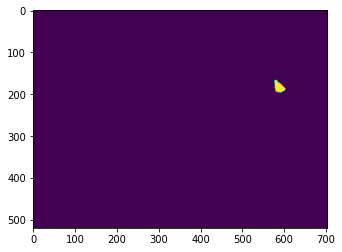

In [4]:
rle = train_df.loc[0, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, 704, 520));

## Function that builds the .json file

In [5]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed

def annotate(idx, row, cat_ids):
        mask = rle2mask(row['annotation'], row['width'], row['height']) # Binary mask
        c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
        c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
        area = maskUtils.area(c_rle).item() # calculating the area
        bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
        annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':0,
            'id':idx
        }
        return annotation
    
def coco_structure(df, workers = 10):
    
    ## Building the header
    cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id, "supercategory" :'cells' } for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

## Running for the whole DF and saving it as a .json file

In [6]:
# import json,itertools
# root = coco_structure(df)

In [7]:
# train = train_df[train_df.id.isin(X_train)]
# (train.shape, train_df.shape, len(X_train))

In [8]:
train = train_df[train_df.id.isin(X_train)]
root = coco_structure(train)

with open(  os.path.join( dataDir, 'DETECTRON_FILES',  'annotations_train.json')  , 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

  0%|          | 0/58968 [00:00<?, ?it/s]

In [9]:
#VAL
val = train_df[train_df.id.isin(X_test)]
root = coco_structure(val)

with open(   os.path.join( dataDir, 'DETECTRON_FILES', 'annotations_val.json')  , 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

  0%|          | 0/14617 [00:00<?, ?it/s]

In [12]:
#ALL
#val = train_df[train_df.id.isin(X_test)]
root = coco_structure(train_df)

with open(    os.path.join( dataDir, 'DETECTRON_FILES', 'annotations_all.json'   ), 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

  0%|          | 0/73585 [00:00<?, ?it/s]

In [13]:
root['annotations'][0]

{'segmentation': {'size': [520, 704],
  'counts': 'WeT97Q`0<D6J2N1O01O101N1O1O0010O01O1O1N2O1N2O1N2O1N2O1N2N2M_Sc1'},
 'bbox': [576, 167, 27, 30],
 'area': 498,
 'image_id': '0030fd0e6378',
 'category_id': 1,
 'iscrowd': 0,
 'id': 0}

In [14]:
# with open('annotations_train.json', 'w', encoding='utf-8') as f:
#     json.dump(root, f, ensure_ascii=True, indent=4)

# Sanity check

In [15]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [16]:
#dataDir=Path('../input/sartorius-cell-instance-segmentation')
annFile = Path(  os.path.join( dataDir, 'DETECTRON_FILES','./annotations_train.json') )
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


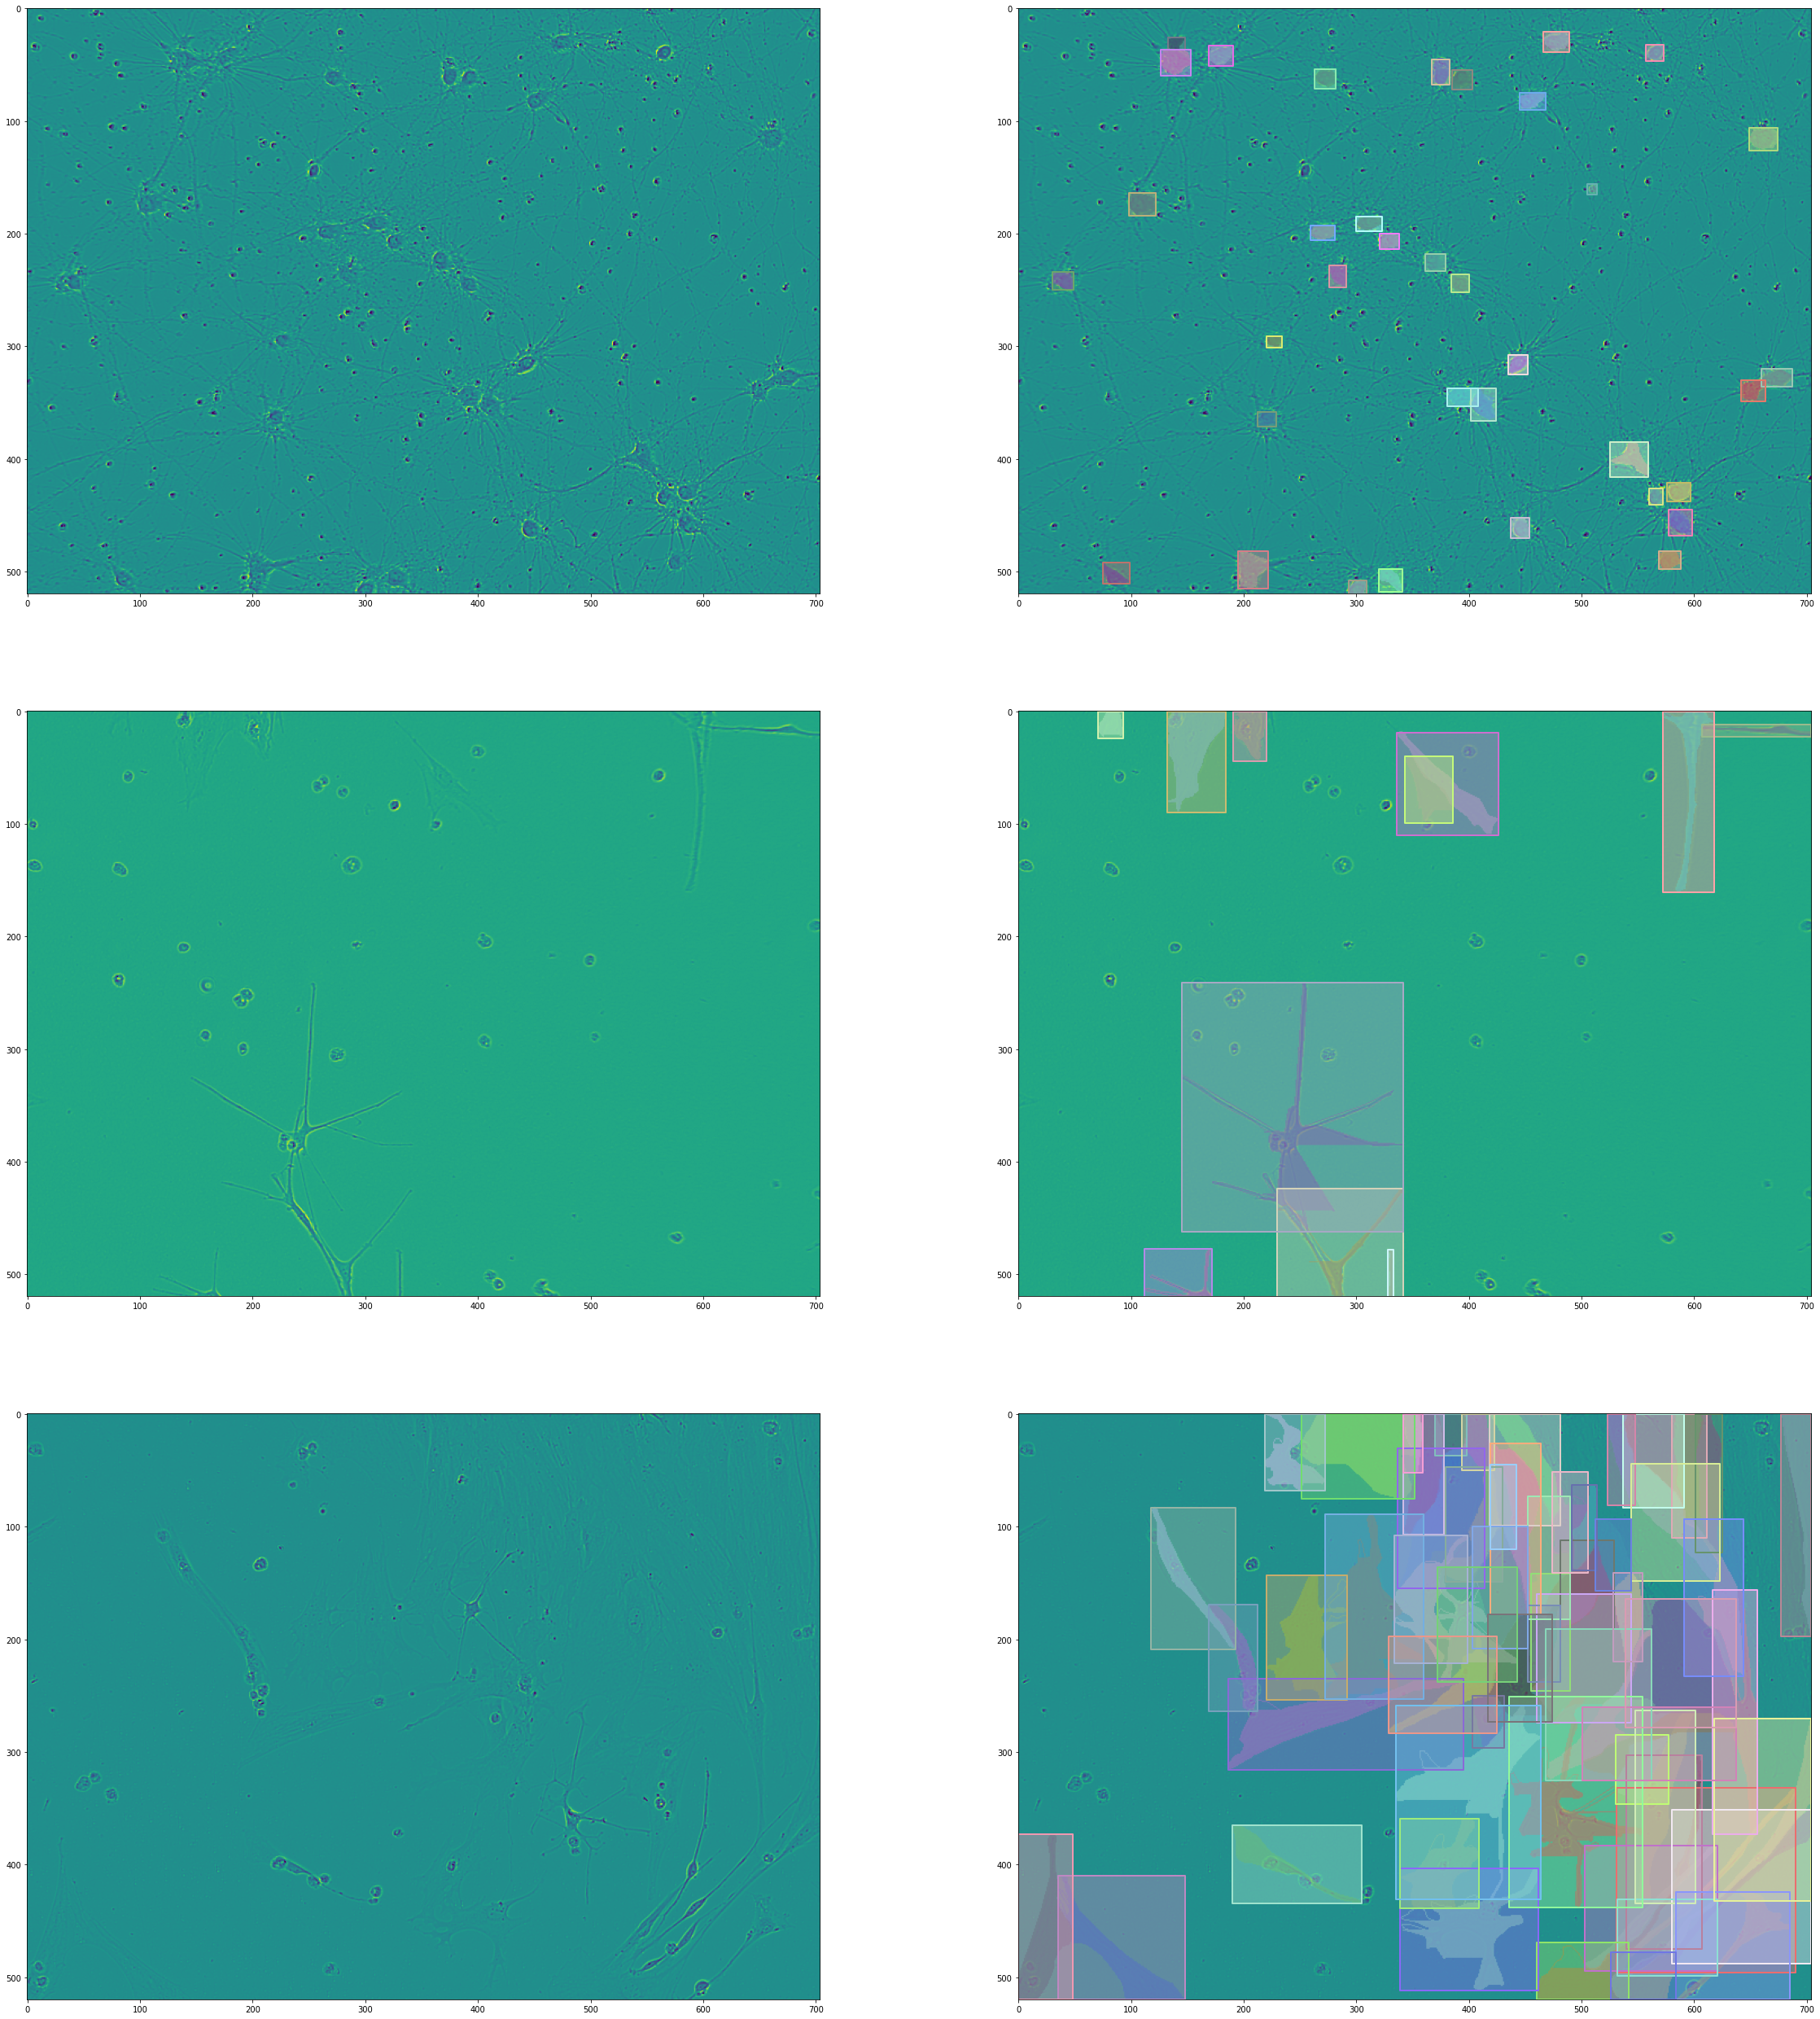

In [17]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir+img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

# For one class

In [4]:
dataDir=  ('C:/kaggletemp/sartorius-cell-instance-segmentation/')

train_df = pd.read_csv( os.path.join( dataDir,'train.csv') )
df = train_df.groupby('id')['cell_type'].first().reset_index()
df.cell_type.unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [24]:
df.groupby('cell_type').count()

,id
cell_type,
astro,131
cort,320
shsy5y,155


In [25]:
ids = df.cell_type.unique()
for i in ids:
    type =   df[df.cell_type.isin( [str(i)] )]

    train, test = train_test_split(  type  , test_size=0.2)

    print (train.shape,test.shape)
    train = train_df[ train_df.id.isin(train.id)]
    test =  train_df[ train_df.id.isin( test.id)]
    root_train= coco_structure(train)
    root_test =  coco_structure(test)

    with open(   os.path.join( dataDir, 'DETECTRON_FILES', 'annotations_' + str(i) + 'train'+ '.json')  , 'w', encoding='utf-8') as f:
        json.dump(root_train, f, ensure_ascii=True, indent=4)
    with open(   os.path.join( dataDir, 'DETECTRON_FILES', 'annotations_' + str(i) +  'test' + '.json')  , 'w', encoding='utf-8') as f:
        json.dump(root_test, f, ensure_ascii=True, indent=4)

(124, 2) (31, 2)


  0%|          | 0/42147 [00:00<?, ?it/s]

  0%|          | 0/10139 [00:00<?, ?it/s]

(104, 2) (27, 2)


  0%|          | 0/8693 [00:00<?, ?it/s]

  0%|          | 0/1829 [00:00<?, ?it/s]

(256, 2) (64, 2)


  0%|          | 0/8541 [00:00<?, ?it/s]

  0%|          | 0/2236 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
df = train_df.groupby('id')['cell_type'].first().reset_index()

dataDir=  ('C:/kaggletemp/sartorius-cell-instance-segmentation/')
i = 'cort'
train_df = pd.read_csv( os.path.join( dataDir,'train.csv') )

type =  df[df.cell_type.isin( [str(i)] )]
train, test = train_test_split(  type  , test_size=0.2)
(train.shape, test.shape)